# Standard Step Method: 應用 Python 求解

## 基本方程式

以梯形渠道為例，底寬為 $b$, 側邊斜率為 $H/V = m$, 可得

水面寬 $$B = b + 2my$$

濕周 $$P = b + 2y\sqrt{1+m^2}$$

面積 $$A = (b+my)y$$

水力半徑 $$R = \frac{(b+my)y}{b+2y\sqrt{1+m^2}}$$

比能之坡降為

$$
\frac{dE}{dx} = S_0 - S_f
$$

其中比能 $E$ 為

$$
E = y + \frac{Q^2}{2gA^2}
$$

運用 Manning 公式，可得能量坡度為

$$
S_f = \left(\frac{nQ}{\kappa A R^{2/3}} \right)^2
$$

若為公制 $\kappa = 1.0$, 英制則 $\kappa = 1.486$。

### 朝上游計算

給定流量 $Q$，設下游斷面 1 之水深 $y_1$ 已知，欲求上游斷面 2 之水深 $y_2$。將比能坡降近似為

$$
\frac{E(y_1)-E(y_2)}{\Delta x} = S_0 - \bar{S_f} = S_0 - \frac{1}{2}(S_f(y_1)+S_f(y_2))
$$

可得

$$
U(y_2) = U(y_1) + [S_f(y_1)-S_0]\Delta x
$$

其中 $U(y) = E(y) - \frac{1}{2} S_f(y) \Delta x$。當 $U(y_2)$ 的值已知時，可使用 Python 的求根函式解出 $y_2$。

## 函式

In [1]:
import numpy as np
from scipy.optimize import root_scalar
import matplotlib.pyplot as plt

def compute_Sf(y, Q, n, b, m):
    A = y * (b + m * y)
    P = b + 2 * y * np.sqrt(1 + m**2)
    R = A / P
    return (n**2 * Q**2) / (1.49**2 * A**2 * R**(4/3))

def compute_E(y, Q, b, m, g=32.174):
    A = y * (b + m * y)
    return y + Q**2 / (2 * g * A**2)

def U(y, Q, n, b, m, dx):
    Sf = compute_Sf(y, Q, n, b, m)
    E = compute_E(y, Q, b, m)
    return E - 0.5 * Sf * dx

def solve_next_depth(y1, Q, n, b, m, S0, dx, y_guess=None):
    """
    根據下游水深 y1，反推上游距離 dx 處之水深 y2。
    """
    Sf1 = compute_Sf(y1, Q, n, b, m)
    U1 = U(y1, Q, n, b, m, dx)
    U_target = U1 + (Sf1 - S0) * dx

    def residual(y2):
        return U(y2, Q, n, b, m, dx) - U_target

    # 選擇合理的初始猜測區間（可根據 y1 上下微調）
    if y_guess is None:
#        y_guess = [0.1, y1 * 2]
         y_guess = [y1, y1*2]

    sol = root_scalar(residual, method='brentq', bracket=y_guess)
    if sol.converged:
        return sol.root
    else:
        raise RuntimeError("Root finding failed for y2.")

def compute_profile(x_array, y1, Q, n, b, m, S0):
    """
    給定下游初始水深 y1，沿 x_array 自下游至上游計算水面線。
    """
    N = len(x_array)
    y_array = np.zeros(N)
    y_array[-1] = y1  # 下游已知水深在最後一格

    for i in reversed(range(N - 1)):
        dx = x_array[i + 1] - x_array[i]
        y_array[i] = solve_next_depth(
            y_array[i + 1], Q, n, b, m, S0, dx
        )
    return y_array

## 例題一

x = -1200.0 ft,  y = 6.0676 ft
x = -1175.5 ft,  y = 6.0573 ft
x = -1151.0 ft,  y = 6.0467 ft
x = -1126.5 ft,  y = 6.0358 ft
x = -1102.0 ft,  y = 6.0246 ft
x = -1077.6 ft,  y = 6.0131 ft
x = -1053.1 ft,  y = 6.0013 ft
x = -1028.6 ft,  y = 5.9891 ft
x = -1004.1 ft,  y = 5.9766 ft
x = -979.6 ft,  y = 5.9637 ft
x = -955.1 ft,  y = 5.9504 ft
x = -930.6 ft,  y = 5.9367 ft
x = -906.1 ft,  y = 5.9226 ft
x = -881.6 ft,  y = 5.9080 ft
x = -857.1 ft,  y = 5.8929 ft
x = -832.7 ft,  y = 5.8774 ft
x = -808.2 ft,  y = 5.8613 ft
x = -783.7 ft,  y = 5.8447 ft
x = -759.2 ft,  y = 5.8275 ft
x = -734.7 ft,  y = 5.8097 ft
x = -710.2 ft,  y = 5.7912 ft
x = -685.7 ft,  y = 5.7721 ft
x = -661.2 ft,  y = 5.7522 ft
x = -636.7 ft,  y = 5.7316 ft
x = -612.2 ft,  y = 5.7101 ft
x = -587.8 ft,  y = 5.6878 ft
x = -563.3 ft,  y = 5.6645 ft
x = -538.8 ft,  y = 5.6402 ft
x = -514.3 ft,  y = 5.6148 ft
x = -489.8 ft,  y = 5.5882 ft
x = -465.3 ft,  y = 5.5604 ft
x = -440.8 ft,  y = 5.5312 ft
x = -416.3 ft,  y = 5.5004 ft
x

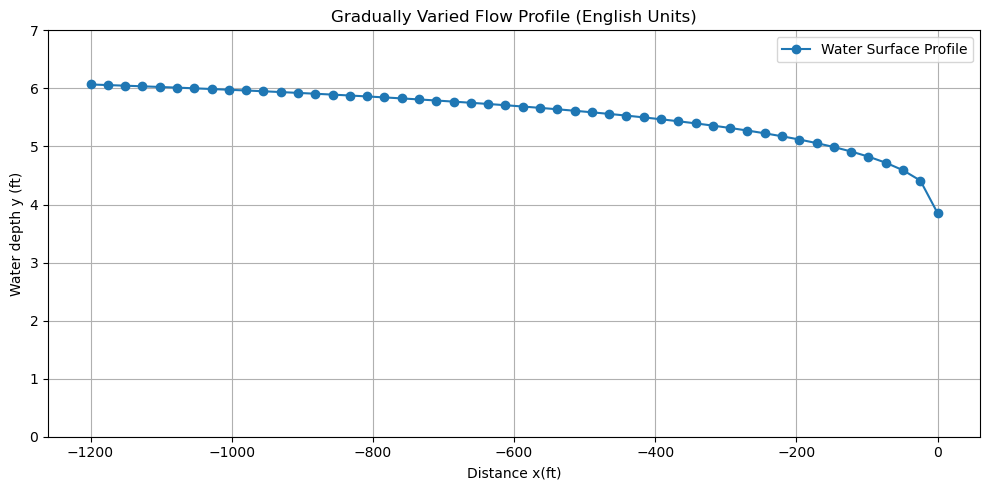

In [2]:
# 空間點（從下游至上游）
x_vals = np.linspace(-1200, 0, 50)
#x_vals = np.array([-1200, -900, -600, -300, -200, -100, -50, 0])

y1 = 3.85  # 下游已知水深

# 渠道與流況參數
Q = 1000.0   # cfs
n = 0.025
b = 20       # ft
m = 1.5
S0 = 0.001   # 床坡

# 計算水面線
y_profile = compute_profile(x_vals, y1, Q, n, b, m, S0)

# 顯示結果
for x, y in zip(x_vals, y_profile):
    print(f"x = {x:.1f} ft,  y = {y:.4f} ft")

# --- 繪圖 ---
plt.figure(figsize=(10, 5))
plt.plot(x_vals, y_profile, marker='o', label="Water Surface Profile")
#plt.gca().invert_xaxis()  # 從下游往上游畫
plt.xlabel("Distance x(ft)")
plt.ylabel("Water depth y (ft)")
plt.title("Gradually Varied Flow Profile (English Units)")
plt.grid(True)
plt.ylim(0,7)
plt.legend()
plt.tight_layout()
plt.show()